 # Agrimetrics CropLens AI™ examples

 © 2021 Agrimetrics

 [Agrimetrics CropLens AI™](https://app.agrimetrics.co.uk/catalog/data-sets/f98daefb-f1c4-4f2f-aad5-c566e8695c49/overview)
 is a crop identification service developed by Agrimetrics. It predicts the crop type of a field from one of five categories:
 Oilseed Rape, Winter Wheat, Winter Barley, Grass, and "other". Predictions can be made from any time between January 2017
 and the present day, for any field in the [Agrimetrics UK Field Boundaries](https://app.agrimetrics.co.uk/catalog/data-sets/00fc5587-793d-4119-867a-27b2136520a7/overview)
 dataset. Crop type is predicted by a machine learning model from [Sentinel-1 Synthetic Aperture Radar (SAR)](https://sentinel.esa.int/web/sentinel/missions/sentinel-1)
 observations on the field of interest.

 ## Availability
 Agrimetrics CropLens AI™ predictions are available on demand for 2.7 million field boundaries in England, Wales, Scotland, and Nothern Ireland.
 Predictions are updated every 6 days with the latest SAR acquisitions over a field boundary [Agrimetrics Field-attributed SAR data](https://app.agrimetrics.co.uk/catalog/data-sets/2f00e420-09fb-4310-92a5-46df6ef00d2a/overview).
 Predictions can be obtained from January 2017 to the present day.

 ## GraphQL access
 Agrimetrics CropLens AI™ predictions are accessible using the [Agrimetrics GraphQL API](https://app.agrimetrics.co.uk/graph-explorer).
 You can learn about the GraphQL API and obtain your API key through the [Developer Portal](https://developer.agrimetrics.co.uk/).
 You can also register interests and conduct queries using our [Query Builder](https://app.agrimetrics.co.uk/graph-explorer) application, which provides a browser based mechanism to execute GraphQL API queries.
 Predictions are available after registering fields of interest in GraphQL.

 ### Field registration
 Below are the basic requirements for using the Agrimetrics GraphQL API for querying the CropLens AI™ data.
 An API key can be set as an environment variable or entered manually. GraphQL queries are posted
 to the API endpoint using the python `requests` package.

In [1]:
import requests
import os

API_KEY = os.getenv("API_KEY") or input("Enter Agrimetrics GraphQL API key")


def graphql(query, **variables):
    headers = {
        "Accept": "application/json",
        "Ocp-Apim-Subscription-Key": API_KEY,
        "Content-Type": "application/json",
        "Accept-Encoding": "gzip, deflate, br",
    }

    response = requests.post(
        "https://api.agrimetrics.co.uk/graphql",
        headers=headers,
        json={"query": query, "variables": variables},
    )
    response.raise_for_status()
    results = response.json()
    errors = results.get("errors")
    if errors:
        raise Exception(f"GraphQL query errors: {errors}")

    return results["data"]



 First, we find the cost of registering a field using the Agrimetrics CropLens AI™:

In [2]:
def cost(field_id, season):
    query = """
        query getCropLensAICost($field_id: ID!, $season: CropLiveSeason!){
            account {
                premiumData {
                    cropPredictionRegistrationsCost(registrations: {fieldId: $field_id, season: $season}) {
                        cost
                    }
                }
            }
        }
    """
    results = graphql(query, field_id=field_id, season=season)
    return results["account"]["premiumData"]["cropPredictionRegistrationsCost"][0]["cost"]


field_id = "agfd:vmK8rfUIeruj4ihV_nRk0g"

historical_cost = cost(field_id, "OCT2016TOSEP2020")
current_cost = cost(field_id, "OCT2020TOSEP2021")
print(f"Historical registration cost (October 2016 - September 2020): {historical_cost} credits")
print(f"Current registration cost    (October 2020 - September 2021): {current_cost} credits")



Historical registration cost (October 2016 - September 2020): 0 credits
Current registration cost    (October 2020 - September 2021): 0 credits


 The field chosen for this example is an Agrimetrics trial field, for which data is available for free.
 To see the full list of trial fields, please consult the [documentation](https://developer.agrimetrics.co.uk/product-trial).
 We register for historical and current crop type predictions:

In [3]:
def register(field_id, season):
    mutation = """
        mutation registerCropLensAI($field_id: ID!, $season: CropLiveSeason!){
            account {
                premiumData {
                    addCropPredictionRegistrations(registrations: {fieldId: $field_id, season: $season}) {
                        cost
                        success
                    }
                }
            }
        }
    """

    results = graphql(mutation, field_id=field_id, season=season)
    registration = results["account"]["premiumData"]["addCropPredictionRegistrations"][0]
    return registration["cost"], registration["success"]


historical_cost, historical_success = register(field_id, "OCT2016TOSEP2020")

if historical_success:
    print(f"Successfully registered historical predictions on {field_id} for {historical_cost} credits")
else:
    print(f"Failed to register historical predictions on      {field_id} for {historical_cost}")


current_cost, current_success = register(field_id, "OCT2020TOSEP2021")

if current_success:
    print(f"Successfully registered current predictions on    {field_id} for {current_cost} credits")
else:
    print(f"Failed to register current predictions on         {field_id} for {current_cost} credits")


Successfully registered historical predictions on agfd:vmK8rfUIeruj4ihV_nRk0g for 0 credits
Successfully registered current predictions on    agfd:vmK8rfUIeruj4ihV_nRk0g for 0 credits


 ### Field predictions
 Agrimetrics CropLens AI™ field predictions are obtained after registration.
 Here we predict crop types 4 times a month from January 2017 to the present day.

In [4]:
def predictions(field_id, date):
    query = """
        query getFieldPredictions($field_id: ID!, $date: DateTime!){
            fields(filter: {id: $field_id}) {
                predictedSownCrop(where: {dateTime: {EQ: $date}}) {
                    confidenceProbability
                    cropType
                }
            }
        }
    """
    results = graphql(query, field_id=field_id, date=date)
    predictions = results["fields"][0]["predictedSownCrop"]
    return predictions


field_predictions = []
for year in [2017, 2018, 2019, 2020, 2021]:
    for month in range(1, 13 if year != 2021 else 7):
        for day in [3, 10, 17, 25]:
            date = f"{year}-{month:02}-{day:02}T00:00:00.000Z"
            date_predictions = predictions(field_id, date)
            for crop_type_prediction in date_predictions:

                field_predictions.append(
                    {
                        "field_id": field_id,
                        "Date": date,
                        "Crop": crop_type_prediction["cropType"],
                        "Probability": crop_type_prediction["confidenceProbability"],
                    }
                )

import pandas as pd

field_predictions = pd.DataFrame(field_predictions)
field_predictions["Date"] = pd.to_datetime(field_predictions["Date"]).dt.date


 ## Exploring crop rotations
 With the confidence probabilities obtained in the previous step, we can explore the crop rotation on our field of interest.

/tmp/ipykernel_2558/3578881697.py:12: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.tight_layout()
/home/piero/agrimetrics-radish/env/fotw/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  fig.canvas.print_figure(bytes_io, **kw)


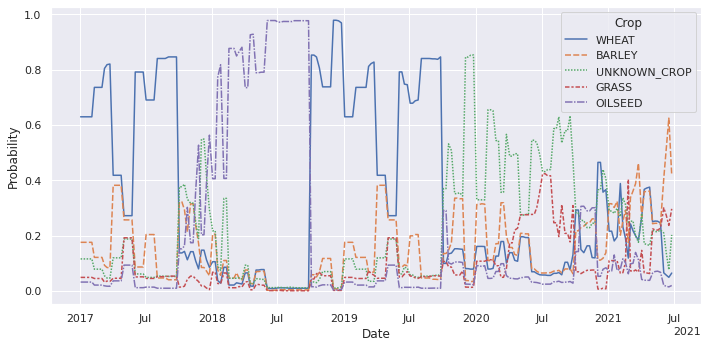

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set()
plt.figure(figsize=(10, 5))
ax = sns.lineplot(data=field_predictions, x="Date", y="Probability", hue="Crop", style="Crop")
locator = mdates.AutoDateLocator(maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.tight_layout()


 We extract here the most likely crop type for each of the predicted dates:

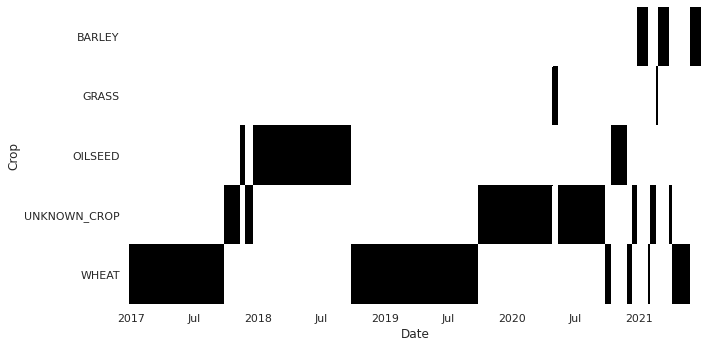

In [6]:
crop_types = pd.pivot_table(field_predictions, values="Probability", columns="Crop", index=["Date"])
likely_crop = crop_types.idxmax(axis=1)
crop_rotation = crop_types.apply(lambda ct: ct.name == likely_crop).transpose()
crop_rotation.sort_index(axis=1, inplace=True)


def xticklabel(date):
    if date.day == 3 and date.month == 1:
        return str(date.year)
    if date.day == 3 and date.month == 7:
        return "Jul"


xticklabels = [xticklabel(date) for date in crop_rotation.columns]
plt.figure(figsize=(10, 5))
ax = sns.heatmap(crop_rotation, cbar=False, cmap="binary", xticklabels=xticklabels)
plt.tight_layout()


 The rotation on the chosen field is winter wheat harvested in 2017, followed by oilseed rape in 2018,
 winter wheat again in 2019, and another crop in 2020. Results for 2021 are still uncertain for this field;
 the predicted crop type alternates mostly between wheat and barley.

 ## Regional area estimation
 Agrimetrics CropLens AI™ can be used to produce regional and national estimates
 of the hectarage of Oilseed Rape, Winter Wheat, Winter Barley and Grass.
 In the figures below, we compare the predicted areas of Winter Wheat, Winter Barley
 and Oilseed Rape in 3 contrasting English regions with official statistics.
 Final statistics are published in the following winter.
 Agrimetrics CropLens AI™ predictions presented here were obtained for August 2018-2020 and June 2021
 on only 5% of the fields from each region (52270 fields in total, covering 208,801 hectares).

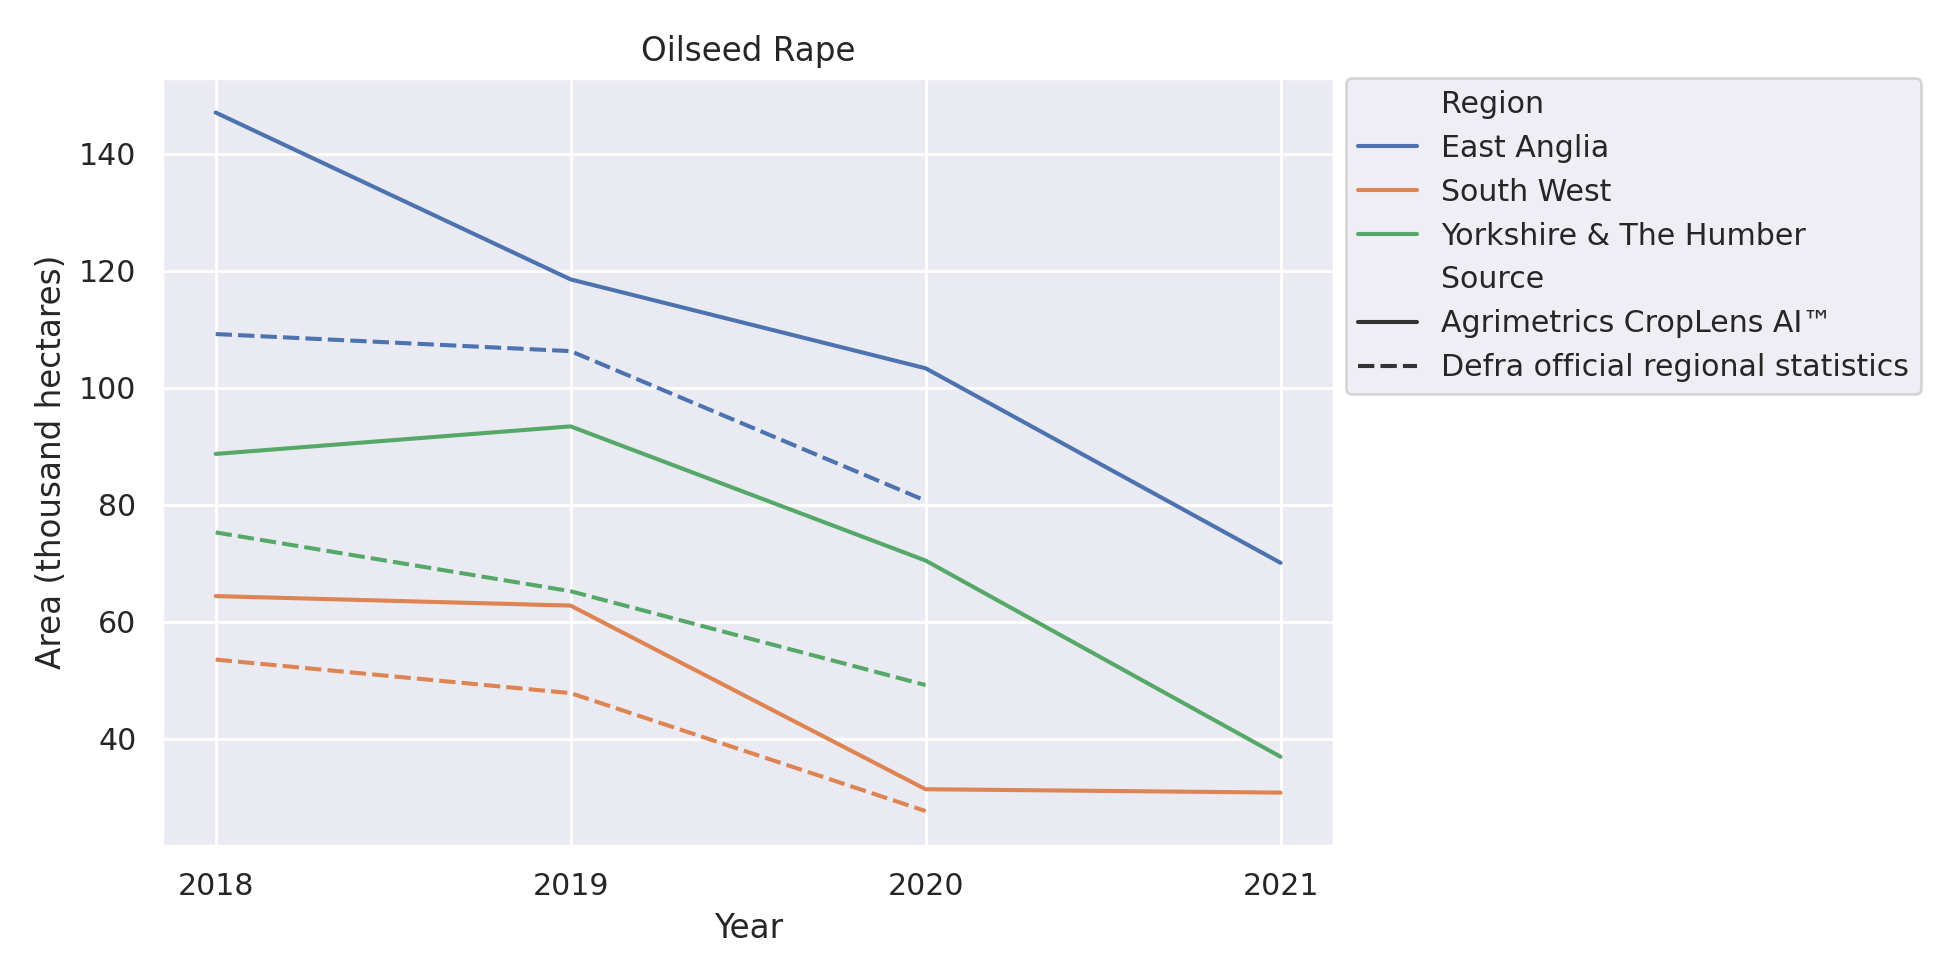

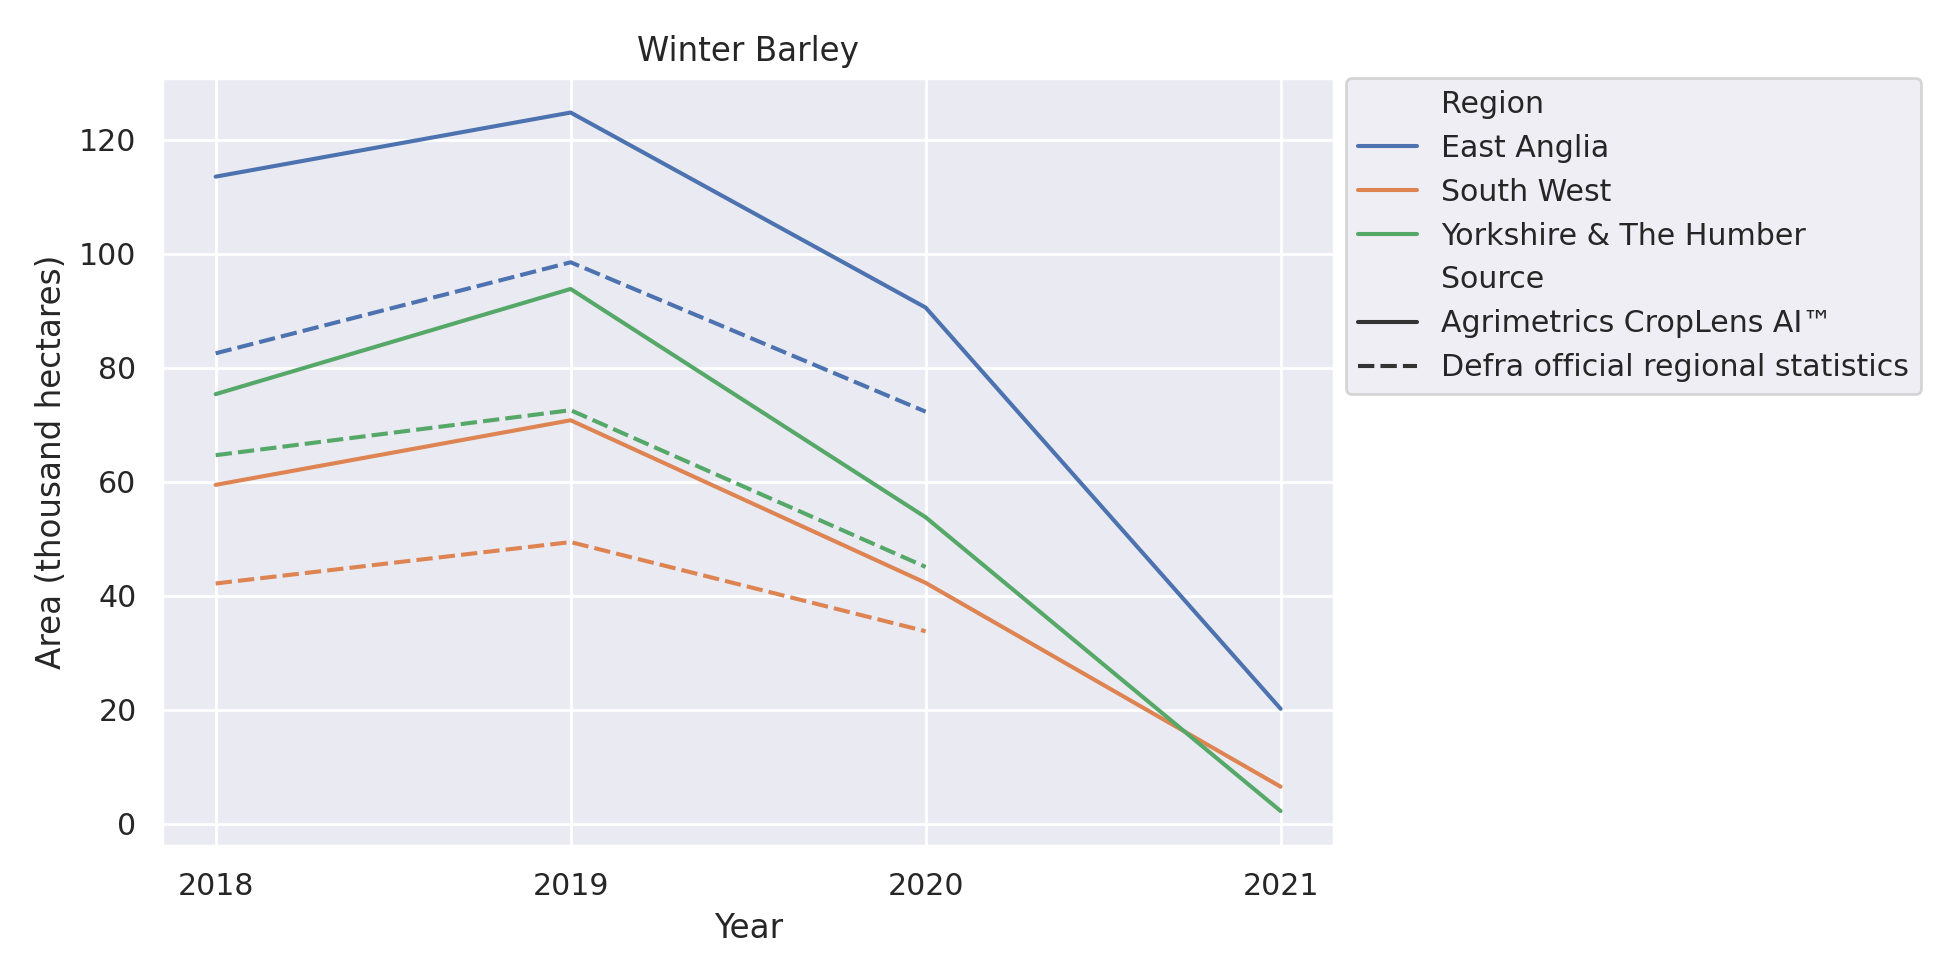

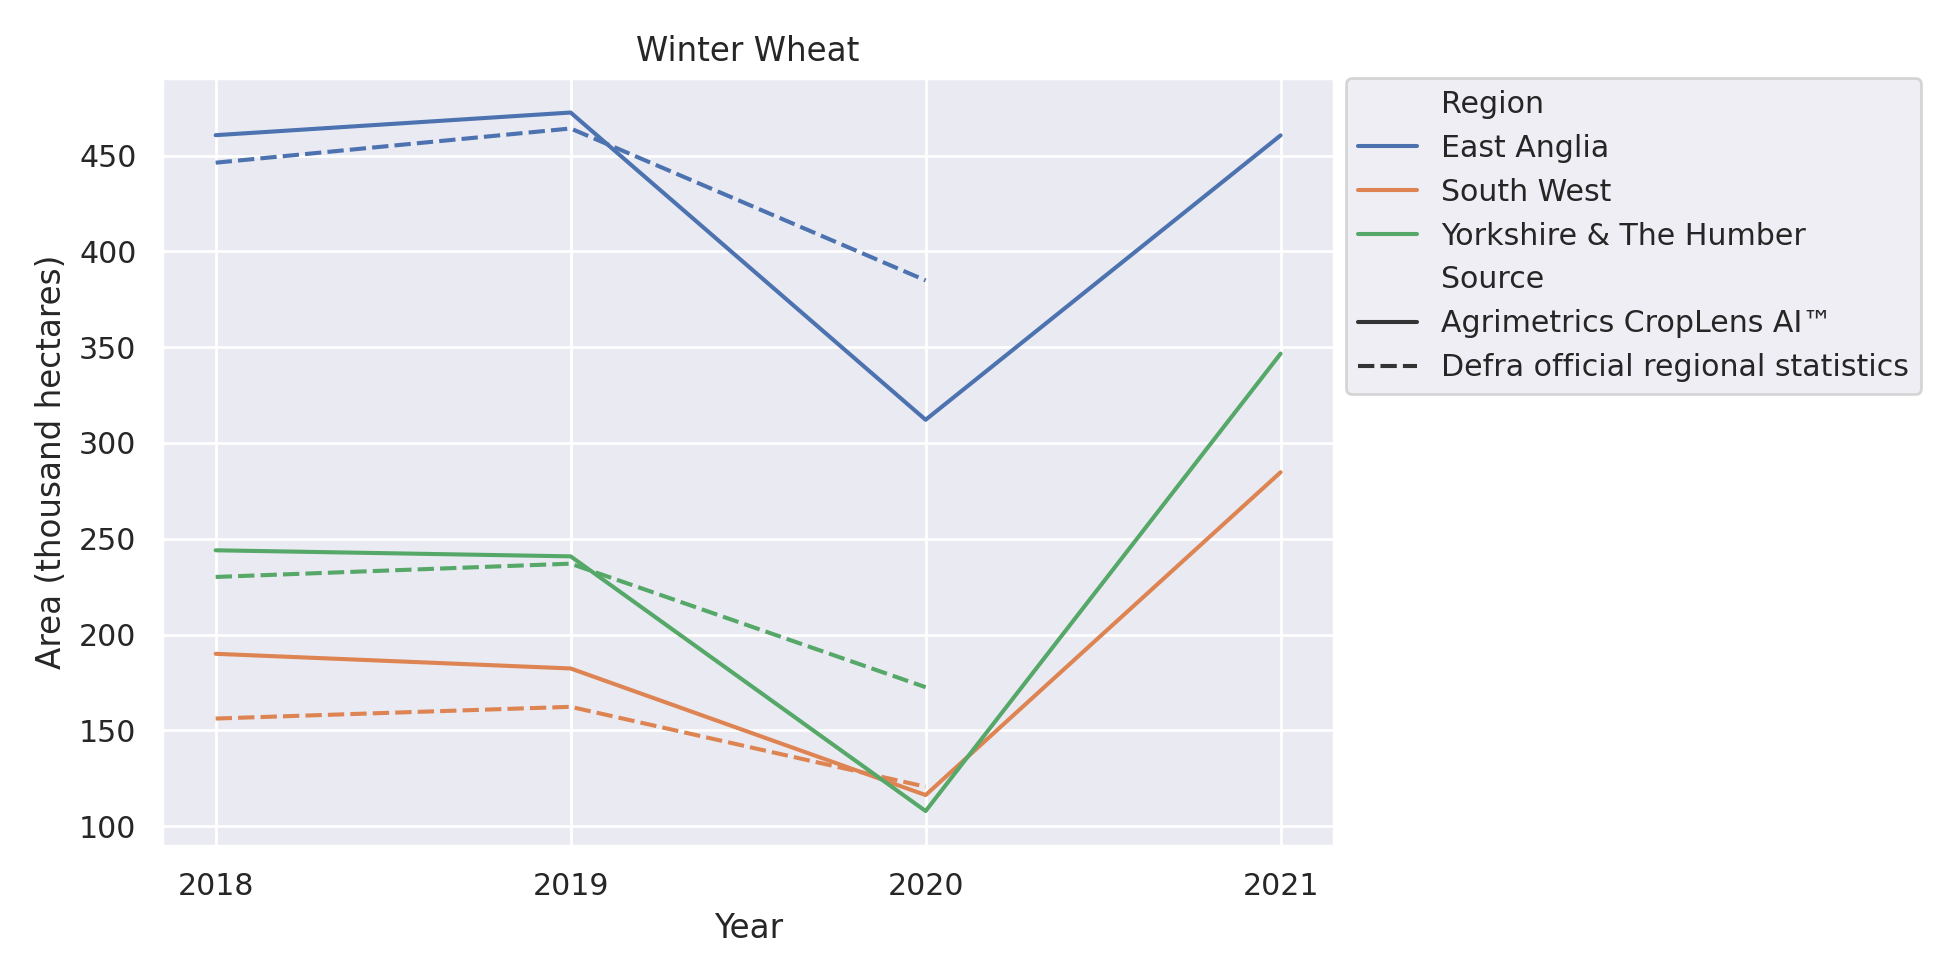